In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os, sys
sys.path.append('..')
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from time import time, strptime, mktime
torch.manual_seed(0)
np.random.seed(0)

In [4]:
sample_file = '/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt'

In [5]:
def collect(byf, fname, verbose=True):
    res = []
    li = 0
    added = 0
    with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt') as fl:
        _ = fl.readline()
        line = fl.readline()
        while line:
            if 'NULL' not in line and 'IN_PROGRESS' in line:
                obj = byf(line)
                if obj is not None:
                    res.append(obj)
                    added += 1
            line = fl.readline()
            li += 1
            if li % 10000 == 0 and verbose:
                sys.stdout.write('%d       \r' % li)
        if verbose: sys.stdout.flush()
    if verbose: print('Collected %d/%d' % (added, li))
    return res

def by(line):
#     if root in line:
    try:
        fobj = fmt(line)
        bus_id = fobj['routeid'].split('_')[1]
        if 'X' not in bus_id:
            return fobj
    except:
        print(line)
        assert False
    return None

raw_seghist = collect(by, sample_file)

Collected 3827194/5503372


In [6]:
print(len(raw_seghist))

3827194


In [228]:
byroute = group(raw_seghist, 'routeid')
print(len(byroute.keys()))

231


In [8]:
scodes = {}
for stop in raw_seghist:
    scode = stop['stop'].split('_')[1]
    scodes[scode] = True
print(len(scodes.keys()))
print(list(scodes.keys())[:5])

12719
['402644', '306665', '300529', '405155', '307819']


In [181]:
bybus = group(raw_seghist, 'busid')
print(len(bybus.keys()))

3582


In [126]:
raw_seghist[0]

{'busid': '3666',
 'direction': 0,
 'dist': 7784.000404746534,
 'phase': True,
 'routeid': 'MTABC_Q111',
 'stop': 'MTA_552345',
 'time': time.struct_time(tm_year=2014, tm_mon=10, tm_mday=30, tm_hour=4, tm_min=0, tm_sec=1, tm_wday=3, tm_yday=303, tm_isdst=-1)}

In [256]:
def next_stops(travel, adj={}):
    prevseg = None
    prev = travel[0]
    
    for _, stop in enumerate(travel[1:]):
        if stop['stop'] != prev['stop']:
            if np.abs(prev['dist'] - stop['dist']) > 2.5 * 1000:
                # sensor reset? or loop-around... either way unreliable
                # should be okay to ignore when inferring stops from lots of data
                pass
            elif mktime(stop['time']) - mktime(prev['time']) > 45 * 60:
                # skip if >1hr difference
                pass
            else:
                if prev['stop'] == 'MTA_903147' and stop['stop'] == 'MTA_404008':
                    print('>')
                    print(stop)
                    print('=')
                    print(prev)
                if prev['stop'] not in adj: adj[prev['stop']] = {}
                if stop['stop'] not in adj[prev['stop']]: adj[prev['stop']][stop['stop']] = []
                adj[prev['stop']][stop['stop']].append((prev, stop))
            prev = stop
#             pdist = stop['dist']
#     return adj

byroute = group(raw_seghist, 'routeid')
print(len(byroute.keys()))

route_adjs = {}
for rid, route in byroute.items():
# for rid, route in tqdm(byroute.items()):
    

    bydir = group(route, 'direction')
    for dir, direction in bydir.items():
        adj = {}
        bytravel = group(direction, 'busid', kf=lambda key: key.replace('+', ''))
        for bid, travel in bytravel.items():
            next_stops(travel, adj)

#         print(dir, rid, len(bytravel.keys()), len(adj))

        route_adjs['%d_%s' % (dir, rid)] = adj

231


In [251]:
print(len(route_adjs['1_MTA NYCT_M101']))
# route_adjs['1_MTA NYCT_M101']
for next, ls in route_adjs['1_MTA NYCT_M101']['MTA_903147'].items():
    print(next, len(ls), ls[0][1]['dist'], ls[0][0]['dist'])

80
MTA_903148 3 17080.51000699644 17098.10616502553


In [36]:
sname = '../data/next_stops/%s.json' % sample_file.split('.')[1]

with open(sname, 'w') as fl:
    json.dump(route_adjs, fl)

### Gathering data

In [325]:
dfiles = sorted(glob('../data/next_stops/*.json'))
print(len(dfiles))

90


In [326]:
all_adjs = {}
for fname in dfiles:
    with open(fname) as fl:
        data = json.load(fl)
    
#     print(len(data))
    for rid, byroute in data.items():
        if rid not in all_adjs: all_adjs[rid] = {}
        for sid, nexts in byroute.items():
            if sid not in all_adjs[rid]: all_adjs[rid][sid] = {}
            for next_stop, occur in nexts.items():
                if next_stop not in all_adjs[rid][sid]: all_adjs[rid][sid][next_stop] = 0
                all_adjs[rid][sid][next_stop] += occur
#     break

In [327]:
all_adjs['1_MTA NYCT_M101']['MTA_903147']

{'MTA_402854': 2,
 'MTA_402858': 1,
 'MTA_403418': 1,
 'MTA_403772': 2,
 'MTA_404106': 2,
 'MTA_903148': 120}

In [386]:
def greedy_path(byroute):
    segs = []
    for stop, next_stops in byroute.items():
        slist = list(next_stops.keys())
        slist = sorted(slist, key=lambda st: next_stops[st])
        smax = slist[-1]
        seg = (stop, smax, next_stops[smax])
        segs.append(seg)
    
    maxind = max(range(len(segs)), key=lambda ind: segs[ind][2])
    bag_of_segs = segs[::1]
    bag_of_segs.pop(maxind)
    seq = [segs[maxind]]
#     print(seq)
    found = True
    while found:
        found = False
        next_cands = []
        for si, (st, ed, occ) in enumerate(bag_of_segs):
            if st == seq[-1][1]:
                next_cands.append(si)
        if len(next_cands):
            next_best = max(next_cands, key=lambda ind: bag_of_segs[ind][2])
            seq.append(bag_of_segs[next_best])
            bag_of_segs.pop(next_best)
            found = True
            
        next_cands = [] # previous cands
        for si, (st, ed, occ) in enumerate(bag_of_segs):
            if ed == seq[0][0]:
                next_cands.append(si)
        if len(next_cands):
            next_best = max(next_cands, key=lambda ind: bag_of_segs[ind][2])
            seq = [bag_of_segs[next_best]] + seq
            bag_of_segs.pop(next_best)
            found = True
            
    return seq, bag_of_segs

def remove_skips(seq, bag):
    for st, ed, occ in bag:
        for si, seg in enumerate(seq):
            if st == seg[1]:
                break
#         print(si)
        
    return bag

inf_routes = {}
for rid, byroute in all_adjs.items():
# for rid, byroute in [('0_MTA NYCT_Q12', all_adjs['0_MTA NYCT_Q12'])]:
    dir, _, rname = rid.split('_')
    try:
        with open('../data/stopcodes_sequence/%s_%s.txt' % (rname, dir)) as fl:
            known = fl.read().split('\n')
    except:
        continue
    
    seq, bag_of_segs = greedy_path(byroute)
    assert len(seq) > 0
    bag_of_segs = remove_skips(seq, bag_of_segs)
    
    
#     print(len(known), len(seq))
    guess = [ent[0][4:] for ent in seq] + [seq[-1][1][4:]]
    si, ki = 0, 0
    match = 0
#     print(known[:5])
#     print(guess[:5])
    while ki < len(known):
        found = False
        for ind, stop in enumerate(guess[si:]):
            if known[ki] == stop:
                si += ind
                found = True
                break
        if found:
#             print(ki, si)
            match += 1
        ki += 1
#     print(rid, match, len(guess))
#     for seg in guess:
#         print(seg)
    inf_routes[rid] = (seq, match/len(guess), match/len(known))
#     inf_routes.append(, rid))

In [387]:
rkeys = list(inf_routes.keys())
rkeys = sorted(rkeys, key=lambda key: inf_routes[key][2])[::-1]

for key in rkeys:
    seq, mscore, kscore = inf_routes[key]
    print('M %.2f   K %.2f   [%d] %s' % (mscore, kscore, len(seq), key))

M 0.98   K 0.99   [81] 0_MTA NYCT_M3
M 0.98   K 0.99   [81] 0_MTA NYCT_B8
M 0.97   K 0.99   [78] 1_MTA NYCT_B8
M 0.97   K 0.99   [68] 1_MTA NYCT_B60
M 0.98   K 0.98   [63] 0_MTA NYCT_M7
M 0.97   K 0.98   [58] 0_MTA NYCT_B9
M 0.98   K 0.98   [56] 1_MTA NYCT_B20
M 0.97   K 0.98   [57] 0_MTABC_Q60
M 0.98   K 0.98   [55] 0_MTA NYCT_B57
M 0.96   K 0.98   [56] 1_MTA NYCT_B9
M 0.98   K 0.98   [55] 1_MTA NYCT_M100
M 0.98   K 0.98   [53] 1_MTA NYCT_B57
M 0.98   K 0.98   [53] 0_MTA NYCT_B43
M 0.96   K 0.98   [53] 0_MTA NYCT_B68
M 0.96   K 0.98   [52] 1_MTA NYCT_B68
M 0.96   K 0.98   [51] 1_MTA NYCT_B64
M 0.98   K 0.98   [50] 1_MTA NYCT_B43
M 0.94   K 0.98   [51] 0_MTA NYCT_B62
M 0.98   K 0.98   [46] 1_MTA NYCT_B14
M 0.98   K 0.98   [46] 0_MTABC_Q39
M 0.96   K 0.98   [47] 1_MTA NYCT_M10
M 0.96   K 0.98   [47] 1_MTA NYCT_B69
M 0.98   K 0.98   [45] 1_MTA NYCT_B62
M 0.98   K 0.98   [45] 0_MTA NYCT_B14
M 0.96   K 0.98   [45] 0_MTA NYCT_M10
M 0.94   K 0.98   [46] 1_MTA NYCT_B67
M 0.96   K 0.98   [44] 

In [388]:
print('Kscore: %.4f' % np.mean([tup[1] for tup in inf_routes.values()]))

Kscore: 0.8481


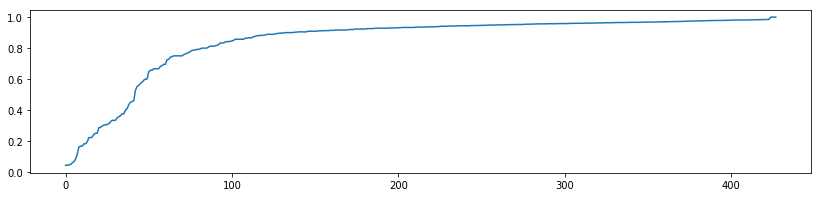

In [389]:
plt.figure(figsize=(14, 3))
plt.plot(sorted([tup[1] for tup in inf_routes.values()]))
plt.show(); plt.close()